# Text Analytics: 5th Assignment (Part 2: Exercise 3)
## MSc in Data Science (2023/2024)

In [1]:
import tasks.preprocessing, tasks.models, tasks.tuning, tasks.util

import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import os

2024-03-11 18:48:58.938503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 18:48:58.938541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 18:48:58.940077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 18:48:58.949531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 18:49:00.155716: W tensorflow/compiler/tf2

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

INPUT_DIR = "input"
INPUT_MODEL_PATH = os.path.join(INPUT_DIR, "models")
OUTPUT_DIR = "output"
INTERMEDIATE_DIR = "intermediate"

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print("Executing with ", gpus[0].name if len(gpus) != 0 else "CPU")

Executing with  /physical_device:GPU:0


2024-03-11 18:49:01.857252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 18:49:01.924397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 18:49:01.924723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Dataset

Acquiring and preprocessing our data with the goal of eventually acquiring a sufficient representation of our text is the most difficult and time-consuming task. We thus split it in distinct phases:

* Original dataset acquisition and parsing
* Qualitative analysis and preprocessing
* Transformation for the NLP task

Note that due to the relative custom code complexity, most of the code used in this section was developed and imported from python source files located in the `tasks` module. In-depth documentation and implementation details can be found in these files. 

In [4]:
print("Loading training dataset...")
train_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-train.conllu"
)
print("Loading validation dataset...")
val_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-dev.conllu"
)
print("Loading test dataset...")
test_df = tasks.preprocessing.conllu_to_pd(
    "input/UD_English-EWT/en_ewt-ud-test.conllu"
)

print(
    f"Training data shape: {train_df.shape}\nValidation data shape: {val_df.shape}"
    "\nTest data shape: {test_df.shape}"
)

Loading training dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/12544 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/12544 [00:00<?, ?it/s]

Loading validation dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2001 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2001 [00:00<?, ?it/s]

Loading test dataset...
	Reading data...
	Parsing data...
	Getting words...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting POS tags...


  0%|          | 0/2077 [00:00<?, ?it/s]

	Getting Sentence ids...


  0%|          | 0/2077 [00:00<?, ?it/s]

Training data shape: (207227, 3)
Validation data shape: (25511, 3)
Test data shape: {test_df.shape}


Below we can see a preview of our parsed training dataset. Our preprocessing exploits pandas's ordering scheme in order to make sure the words are inserted in the order they appear in the sentence. This ordering will prove important later.

In [5]:
train_df

,words,pos,sent_id
0,al,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
1,-,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
2,zaman,PROPN,weblog-juancole.com_juancole_20051126063000_EN...
3,:,PUNCT,weblog-juancole.com_juancole_20051126063000_EN...
4,american,ADJ,weblog-juancole.com_juancole_20051126063000_EN...
...,...,...,...
207222,on,ADP,reviews-319816-0029
207223,my,PRON,reviews-319816-0029
207224,car,NOUN,reviews-319816-0029
207225,),PUNCT,reviews-319816-0029


As mentioned above, our dataset features words connected with punctuation such as "don't". These are normally treated as two words, with the first being their intuitive POS tag ("do" - AUX) and the second as part of the first ("n't" - PART).

This dataset contains both the full words and their split versions, with only the latter featuring valid POS tags. The former are instead marked by a pseudo-tag (here "_").

In [6]:
invalid_idx = train_df.pos == "_"
train_df[invalid_idx]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
704,won't,_,weblog-juancole.com_juancole_20051126063000_EN...
868,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1058,don't,_,weblog-blogspot.com_healingiraq_20040409053012...
1078,doesn't,_,weblog-blogspot.com_healingiraq_20040409053012...
...,...,...,...
207078,couldn't,_,reviews-319816-0025
207091,don't,_,reviews-319816-0025
207096,employees',_,reviews-319816-0025
207164,i'm,_,reviews-319816-0027


In [7]:
" ".join(train_df[invalid_idx].words.unique()[:30])

"don't won't doesn't haven't didn't others it's elena's women's children's i'm people's musharraf's sharon's hamas's right's cannot isn't one's let's reporter's he's that's pakistan's world's bush's military's sharif's can't couldn't"

Below we can see an example of a word being contained both times in the dataset, one in full with the pseudo-tag, and the other as split words with valid POS tags.

In [8]:
train_df.iloc[176:179]

,words,pos,sent_id
176,don't,_,weblog-juancole.com_juancole_20051126063000_EN...
177,do,AUX,weblog-juancole.com_juancole_20051126063000_EN...
178,n't,PART,weblog-juancole.com_juancole_20051126063000_EN...


We thus remove the full words including the pseudo-tag from our datasets, ensuring that all target POS tags will be compliant with the UPOS scheme.

In [9]:
train_df = train_df[~invalid_idx]
val_df = val_df[val_df.pos != "_"]
test_df = test_df[test_df.pos != "_"]

### Qualitative Analysis

We analyze our dataset in two granualities: sentences and individual words. We begin by analyzing how many words are in each sentence, which will give us an idea on the size of context available for each word.

In [10]:
def length_sentences(df: pd.DataFrame) -> float:
    lengths = df.groupby(["sent_id"]).agg(lambda x: len(x))
    return lengths.words


train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

Figure saved to output/ex_2_dataset_stats.png


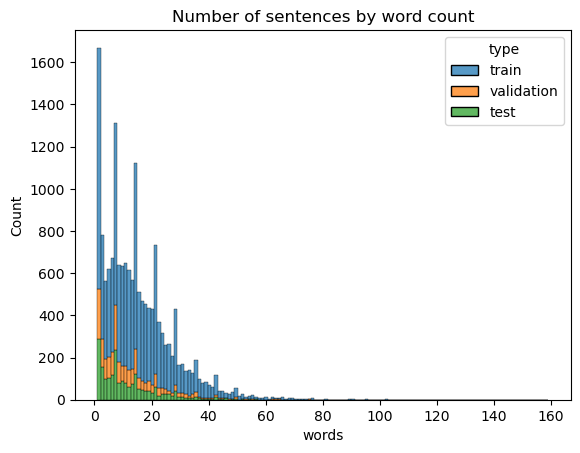

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


stats_df = pd.DataFrame({"words": pd.concat([train_length, val_length, test_length], ignore_index=True),
                        "type": len(train_length)*["train"] +
                         len(val_length)*["validation"] + 
                         len(test_length)*["test"]})

sns.histplot(x="words", 
             hue="type", 
             data=stats_df, 
             multiple="stack")

plt.title("Number of sentences by word count")
tasks.util.save_plot("ex_2_dataset_stats.png", OUTPUT_DIR)
plt.show()

As we can see from the graph above, there is a sizable portion of our sentences that feature very few words. In order to make the RNN training more efficient, we choose to discard sentences with very few words.

In [12]:
def exclude_small_sentences(conllu_df: pd.DataFrame, min_len: int) -> pd.DataFrame:
    assert 1 <= min_len

    length_df = length_sentences(conllu_df)
    valid_length_df = length_df[length_df >= min_len]
    valid_ids = set(valid_length_df.index)
    return conllu_df[conllu_df.sent_id.isin(valid_ids)]

In [13]:
MIN_SENTENCE_LENGTH = 5

train_df = exclude_small_sentences(train_df, MIN_SENTENCE_LENGTH)
val_df = exclude_small_sentences(val_df, MIN_SENTENCE_LENGTH)
test_df = exclude_small_sentences(test_df, MIN_SENTENCE_LENGTH)

train_length = length_sentences(train_df)
val_length = length_sentences(val_df)
test_length = length_sentences(test_df)

In [14]:
train_length.describe()

count    10539.000000
mean        18.967170
std         11.782365
min          5.000000
25%         10.000000
50%         16.000000
75%         24.000000
max        159.000000
Name: words, dtype: float64

In [15]:
val_length.describe()

count    1538.000000
mean       15.607932
std        10.050704
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        75.000000
Name: words, dtype: float64

In [16]:
test_length.describe()

count    1535.000000
mean       15.512052
std        10.332400
min         5.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        81.000000
Name: words, dtype: float64

In [17]:
vocab_size = len(set(train_df.words))
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 15967


In [18]:
print(f"Total word count:\nTraining: {train_df.shape[0]}"
      f"\nValidation: {val_df.shape[0]}"
      f"\nTesting: {test_df.shape[0]}")

Total word count:
Training: 199895
Validation: 24005
Testing: 23811


In [19]:
print(f"Total sentence count:\nTraining: {len(set(train_df.sent_id))}"
      f"\nValidation: {len(set(val_df.sent_id))}"
      f"\nTesting: {len(set(test_df.sent_id))}")

Total sentence count:
Training: 10539
Validation: 1538
Testing: 1535


### Vectorization

In order to make the RNN training more efficient, we choose to discard sentences with very few words. We also set a window size equal to the 90\% percentile of sentence word count, meaning tht 90\% of our windows will fully fit the training sentences. The rest will be automatically split into more sentences, and as such don't need to be excluded from the dataset.

In [20]:
MAX_SEQUENCE_LENGTH = int(np.quantile(train_length, 0.9))
MAX_SEQUENCE_LENGTH

34

We will be using a combination of the `keras.preprocessing.Tokenizer` and `keras.utils.pad_sequences` utilities to create custom windows of words to be fed to our model, since it uses Time Distributed outputs. 

In [21]:
def encode(tokenizer, values):
    return tokenizer.texts_to_sequences(values)


def encode_with_padding(tokenizer, max_seq_len, values):
    tokens = encode(tokenizer, values)
    padded_tokens = keras.utils.pad_sequences(
        tokens, maxlen=max_seq_len, padding="pre", truncating="post"
    )
    return padded_tokens


def decode(tokenizer, encoded_sequence, axis=2):
    return np.array(
        [
            tokenizer.index_word[str(x[-1])]
            for x in np.argmax(encoded_sequence, axis=axis)
        ]
    )

In [22]:
# encode X
word_tokenizer = keras.preprocessing.text.Tokenizer(filters="")
word_tokenizer.fit_on_texts(train_df.words.values)

train_data = encode_with_padding(
    word_tokenizer, MAX_SEQUENCE_LENGTH, train_df.words.values
)
val_data = encode_with_padding(
    word_tokenizer, MAX_SEQUENCE_LENGTH, val_df.words.values
)
test_data = encode_with_padding(
    word_tokenizer, MAX_SEQUENCE_LENGTH, test_df.words.values
)

tag_tokenizer = keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(train_df.pos.values)

# start label counting from 0, since to_categorical assumes argmax = number_of_categories
tag_tokenizer.word_index = {
    key: value - 1 for key, value in tag_tokenizer.word_index.items()
}

# start label counting from 0, since to_categorical assumes argmax = number_of_categories
tag_tokenizer.index_word = {
    str(int(key) - 1): value for key, value in tag_tokenizer.index_word.items()
}

y_train = keras.utils.to_categorical(
    encode_with_padding(tag_tokenizer, MAX_SEQUENCE_LENGTH, train_df.pos.values)
)
y_valid = keras.utils.to_categorical(
    encode_with_padding(tag_tokenizer, MAX_SEQUENCE_LENGTH, val_df.pos.values)
)
y_test = keras.utils.to_categorical(
    encode_with_padding(tag_tokenizer, MAX_SEQUENCE_LENGTH, test_df.pos.values)
)

In [23]:
# check that counting is continuous starting from 0
tag_tokenizer.word_index

{'noun': 0,
 'punct': 1,
 'verb': 2,
 'pron': 3,
 'adp': 4,
 'det': 5,
 'adj': 6,
 'aux': 7,
 'propn': 8,
 'adv': 9,
 'cconj': 10,
 'part': 11,
 'sconj': 12,
 'num': 13,
 'sym': 14,
 'intj': 15,
 'x': 16}

In [24]:
# input shape
y_train.shape

(199895, 34, 17)

## Transformers

We will be using the Transformers library in order to leverage already pretrained BERT models for the POS tagging task.

### Data Representation

We start by splitting our text into individual sentences and loading them in a dataset dict (from the datasets library) in order to properly feed them to our model.

In [25]:
import datasets
import transformers


def encode_bert(df, col_name):
    sentences = []

    for sentence_id in tqdm(set(df.sent_id)):
        words_df = df[df.sent_id == sentence_id]
        sentence = list(words_df[col_name])
        sentences.append(sentence)

    return sentences


def decode_bert(encoded_sequence, num_classes):
    # create dummy class equal to num_classes for -100 tokens
    return keras.utils.to_categorical(
        [x if x != -100 else num_classes for x in encoded_sequence.flatten()],
        num_classes=num_classes + 1,
    )


print("Converting dataframe to individual sentences...")
data_dict = datasets.DatasetDict(
    {
        "train": datasets.Dataset.from_dict(
            {
                "labels": tag_tokenizer.texts_to_sequences(
                    encode_bert(train_df, "pos")
                ),
                "words": encode_bert(train_df, "words"),
            }
        ),
        "val": datasets.Dataset.from_dict(
            {
                "labels": tag_tokenizer.texts_to_sequences(
                    encode_bert(val_df, "pos")
                ),
                "words": encode_bert(val_df, "words"),
            }
        ),
        "test": datasets.Dataset.from_dict(
            {
                "labels": tag_tokenizer.texts_to_sequences(
                    encode_bert(test_df, "pos")
                ),
                "words": encode_bert(test_df, "words"),
            }
        ),
    }
)
data_dict

Converting dataframe to individual sentences...


  0%|          | 0/10539 [00:00<?, ?it/s]

  0%|          | 0/10539 [00:00<?, ?it/s]

  0%|          | 0/1538 [00:00<?, ?it/s]

  0%|          | 0/1538 [00:00<?, ?it/s]

  0%|          | 0/1535 [00:00<?, ?it/s]

  0%|          | 0/1535 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'words'],
        num_rows: 10539
    })
    val: Dataset({
        features: ['labels', 'words'],
        num_rows: 1538
    })
    test: Dataset({
        features: ['labels', 'words'],
        num_rows: 1535
    })
})

The model we will be using is the [Tweebank NLP Bert Model](https://huggingface.co/TweebankNLP/bertweet-tb2_ewt-pos-tagging) which is pretrained on the POS tagging task on a similar dataset to ours.

Unfortunately, while the authors do provide their own tokenizer, it is a "slow" tokenizer, meaning that its API is restricted. Since we need parts of the API to properly align labels and tokens, we will be using another "fast" tokenizer. 

We pick the vanilla bert-base-uncased tokenizer since its unlikely to deviate significantly from the tweebank tokenizer, and we choose the uncased version since, for the reasons mentioned above, we have converted all words to lowercase.

In [26]:
def model_init():
    return transformers.AutoModelForTokenClassification.from_pretrained(
        "TweebankNLP/bertweet-tb2_ewt-pos-tagging",
        num_labels=len(train_df.pos.unique()),
    )


bert_tokenizer = transformers.AutoTokenizer.from_pretrained(
    "bert-base-uncased", use_fast=True
)

print(model_init())

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

An important issue in token classification for BERT models, is that the underlying model does not operate on words as tokens, but to sub-word tokens. This effectively means that for each word we must predict pseudo-tokens followed by the real POS token. 

The modified function below will map each token to multiple pseudo-labels (with the value -100), while the last token will be the actual POS tag from our dataset. We apply this function to all data.

In [27]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = bert_tokenizer(
        examples["words"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=MAX_SEQUENCE_LENGTH,
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(
            batch_index=i
        )  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif (
                word_idx != previous_word_idx
            ):  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


tokenized_data_dict = data_dict.map(tokenize_and_align_labels, batched=True)
tokenized_data_dict

Map:   0%|          | 0/10539 [00:00<?, ? examples/s]

Map:   0%|          | 0/1538 [00:00<?, ? examples/s]

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10539
    })
    val: Dataset({
        features: ['labels', 'words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1538
    })
    test: Dataset({
        features: ['labels', 'words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1535
    })
})

We also add a data collator, which will handle padding for our sentences.

In [28]:
data_collator = transformers.DataCollatorWithPadding(tokenizer=bert_tokenizer)

In order to extract different metrics for each evaluation period, we construct our own compute_metrics function. This is necessary since a lot of custom processing is need for token classification tasks, unlike with binary classification tasks where the code is trivial.

We specifically turn the predictions into a continuous array of one-hot vectors, which can be used by sklearn to compute the metrics. We represent the dummy class (-100) with an extra integer, which is used to create a mask. This mask is applied both to the true labels and predictions, leading to two matrices composed of one-hot-vectors of only valid POS tags. 

In [29]:
def compute_metrics(pred):
    labels = decode_bert(pred.label_ids, len(np.unique(pred.label_ids)))
    preds = decode_bert(pred.predictions.argmax(-1), len(np.unique(pred.label_ids)))

    # ignore dummy label
    mask = labels[:, -1] != 1
    labels = labels[mask]
    preds = preds[mask]

    # calculate accuracy using sklearn's function
    acc = sklearn.metrics.accuracy_score(labels, preds)
    precision = sklearn.metrics.precision_score(
        labels, preds, average="macro", zero_division=0
    )
    recall = sklearn.metrics.recall_score(
        labels, preds, average="macro", zero_division=0
    )
    f1 = sklearn.metrics.f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "val_accuracy": acc,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1
    }

### Hyper parameter tuning and training

We will be using the Trainer class from the transformers library to train models of various hyper-parameters.

* We exploit the gradient_accumulation_steps parameter to simulate a larger batch size, without incurring further GPU VRAM cost
* We set up early stopping with respect to validation accuracy like with the models in previous assignments
* We set the evaluation and save procedures to be executed each 100 steps, in order to strike a balance between the evaluation overhead and accurate statistics
* We provide our compute_metrics function in order to get detailed statistics in every evaluation period


In [30]:
training_args = transformers.TrainingArguments(
    output_dir=OUTPUT_DIR,  # output directory
    num_train_epochs=8,  # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,  # batch size for evaluation
    gradient_accumulation_steps=2,  # Number of update steps (forward passes) to accumulate the gradients for, before performing a backward/update pass
    logging_dir="./logs",  # directory for storing logs
    eval_steps=100,
    save_steps=100,
    evaluation_strategy=transformers.IntervalStrategy.STEPS,
    load_best_model_at_end=True,
    metric_for_best_model = "val_accuracy",
    save_total_limit=3,
    # hyperparameters to be tuned
    learning_rate=1e-5,
    weight_decay=0.01,  # strength of weight decay
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
)

trainer = transformers.Trainer(
    model_init=model_init,  # the instantiated Transformers model to be trained
    args=training_args,  # training arguments, as defined above
    train_dataset=tokenized_data_dict["train"],  # training dataset
    eval_dataset=tokenized_data_dict["val"],  # evaluation dataset
    tokenizer=bert_tokenizer,  # tokenizer
    data_collator=data_collator, # batch creator (padding)
    callbacks=[
        transformers.EarlyStoppingCallback(early_stopping_patience=5)
    ], 
   compute_metrics=compute_metrics    
)

The model features hundreds of millions of parameters making training very expensive. Given that we run our model locally, this places a very heavy restriction on the number of tuning runs we can afford and restraining us from choices we otherwise would like to explore. Namely:

* We only consider one pretrained model. However, this model is a large BERT model pretrained on the same task and very similar dataset. It is therefore improbable that another model could outperform it.
* We do not unfreeze any BERT layers since that would sharply increase the training time. However, as mentioned above, the specific model has been pretrained on the same family of datasets as ours. Thus it is unlikely that the underlying BERT model would "learn" anything new from our fine-tuning.
* We restrict the hyperparameter runs to only 2. However, given the relative lack of hyperparameters to tune, this should not significantly restrict the final performance of our model.

Given the above limitations we define our search space as:
* The learning rate
* The weight decay
* The warmup steps

Unlike keras_tuner, unfortunately we [cannot access automatically the best run](https://discuss.huggingface.co/t/oserror-unable-to-load-weights-from-pytorch-checkpoint-file/3406). Thus we choose the best model by hand from our local files.

In [31]:
def get_search_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-5, 0.1, log=True),
        "warmup_steps": trial.suggest_int("warmup_steps", 100, 500),
    }


# remember to change this to best run directory if get_search_space changes
# I need to do this manually since the transformer devs apparently gave up on
# doing this automatically  
# https://discuss.huggingface.co/t/oserror-unable-to-load-weights-from-pytorch-checkpoint-file/3406
model_dir = "outputgfgf/run-1/checkpoint-2500" 

if not os.path.exists(model_dir):
    best_run = trainer.hyperparameter_search(
        direction="maximize", backend="optuna", n_trials=2, hp_space=get_search_space
    )

[I 2024-03-11 18:54:59,082] A new study created in memory with name: no-name-5615f3ca-5e0d-434c-913f-a6e90814bf80


  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 2.2895572185516357, 'eval_val_accuracy': 0.281227789623312, 'eval_val_precision': 0.20770931162422182, 'eval_val_recall': 0.14807040287477546, 'eval_val_f1': 0.141506418142216, 'eval_runtime': 14.1204, 'eval_samples_per_second': 108.921, 'eval_steps_per_second': 6.87, 'epoch': 0.3}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 1.0403493642807007, 'eval_val_accuracy': 0.6592484008528785, 'eval_val_precision': 0.5308896706467112, 'eval_val_recall': 0.44873890156380436, 'eval_val_f1': 0.4475089794972891, 'eval_runtime': 14.0297, 'eval_samples_per_second': 109.625, 'eval_steps_per_second': 6.914, 'epoch': 0.61}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.7816298604011536, 'eval_val_accuracy': 0.747867803837953, 'eval_val_precision': 0.656236313125712, 'eval_val_recall': 0.5568110557995077, 'eval_val_f1': 0.5792111074382582, 'eval_runtime': 14.058, 'eval_samples_per_second': 109.404, 'eval_steps_per_second': 6.9, 'epoch': 0.91}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.6788504719734192, 'eval_val_accuracy': 0.7778962331201137, 'eval_val_precision': 0.6618899768537495, 'eval_val_recall': 0.6108393753472136, 'eval_val_f1': 0.6236876864192361, 'eval_runtime': 14.1625, 'eval_samples_per_second': 108.597, 'eval_steps_per_second': 6.849, 'epoch': 1.21}
{'loss': 1.6491, 'grad_norm': 2.235081911087036, 'learning_rate': 1.1525954770195341e-05, 'epoch': 1.52}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.6100931167602539, 'eval_val_accuracy': 0.8039712153518124, 'eval_val_precision': 0.6942061131697919, 'eval_val_recall': 0.6289722118969084, 'eval_val_f1': 0.6479404008534901, 'eval_runtime': 13.9919, 'eval_samples_per_second': 109.921, 'eval_steps_per_second': 6.933, 'epoch': 1.52}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.5571183562278748, 'eval_val_accuracy': 0.8213841506751954, 'eval_val_precision': 0.7078465844665469, 'eval_val_recall': 0.6470971435475196, 'eval_val_f1': 0.6674480433616473, 'eval_runtime': 14.1088, 'eval_samples_per_second': 109.01, 'eval_steps_per_second': 6.875, 'epoch': 1.82}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.5246677398681641, 'eval_val_accuracy': 0.8326226012793176, 'eval_val_precision': 0.7116732272522, 'eval_val_recall': 0.6539314690931907, 'eval_val_f1': 0.6731896673573482, 'eval_runtime': 14.1831, 'eval_samples_per_second': 108.439, 'eval_steps_per_second': 6.839, 'epoch': 2.12}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.5061463117599487, 'eval_val_accuracy': 0.8404406538734897, 'eval_val_precision': 0.717730207571798, 'eval_val_recall': 0.6601349590081078, 'eval_val_f1': 0.6784436520977993, 'eval_runtime': 14.3975, 'eval_samples_per_second': 106.824, 'eval_steps_per_second': 6.737, 'epoch': 2.43}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.48714911937713623, 'eval_val_accuracy': 0.8459932480454868, 'eval_val_precision': 0.7162251610890968, 'eval_val_recall': 0.6698892551376994, 'eval_val_f1': 0.6844613929182299, 'eval_runtime': 14.2934, 'eval_samples_per_second': 107.602, 'eval_steps_per_second': 6.786, 'epoch': 2.73}
{'loss': 0.5134, 'grad_norm': 2.4881861209869385, 'learning_rate': 8.822869692757409e-06, 'epoch': 3.03}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.45911985635757446, 'eval_val_accuracy': 0.8549218194740583, 'eval_val_precision': 0.724381200812568, 'eval_val_recall': 0.6780709808013179, 'eval_val_f1': 0.6944893403215192, 'eval_runtime': 14.0326, 'eval_samples_per_second': 109.602, 'eval_steps_per_second': 6.912, 'epoch': 3.03}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.45033904910087585, 'eval_val_accuracy': 0.8594083155650319, 'eval_val_precision': 0.721792554639697, 'eval_val_recall': 0.6784434446119366, 'eval_val_f1': 0.6940331020887488, 'eval_runtime': 14.0479, 'eval_samples_per_second': 109.483, 'eval_steps_per_second': 6.905, 'epoch': 3.34}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.43498703837394714, 'eval_val_accuracy': 0.8638503909026297, 'eval_val_precision': 0.7248721196185203, 'eval_val_recall': 0.6947291627026653, 'eval_val_f1': 0.706272220049348, 'eval_runtime': 14.1154, 'eval_samples_per_second': 108.959, 'eval_steps_per_second': 6.872, 'epoch': 3.64}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.4230602979660034, 'eval_val_accuracy': 0.8669598436389481, 'eval_val_precision': 0.729166449314794, 'eval_val_recall': 0.6916947449673134, 'eval_val_f1': 0.7061393450103848, 'eval_runtime': 14.0887, 'eval_samples_per_second': 109.165, 'eval_steps_per_second': 6.885, 'epoch': 3.95}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.41802892088890076, 'eval_val_accuracy': 0.871090973702914, 'eval_val_precision': 0.7280796746065606, 'eval_val_recall': 0.6950290490512061, 'eval_val_f1': 0.7077968590488897, 'eval_runtime': 14.185, 'eval_samples_per_second': 108.425, 'eval_steps_per_second': 6.838, 'epoch': 4.25}
{'loss': 0.3947, 'grad_norm': 2.7936789989471436, 'learning_rate': 6.119784615319478e-06, 'epoch': 4.55}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.4073221981525421, 'eval_val_accuracy': 0.8735341151385928, 'eval_val_precision': 0.728022690841692, 'eval_val_recall': 0.7039639377683824, 'eval_val_f1': 0.7134383560739861, 'eval_runtime': 13.9546, 'eval_samples_per_second': 110.215, 'eval_steps_per_second': 6.951, 'epoch': 4.55}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.40537986159324646, 'eval_val_accuracy': 0.8746002132196162, 'eval_val_precision': 0.7285198979686421, 'eval_val_recall': 0.7032276511395744, 'eval_val_f1': 0.7131545469763402, 'eval_runtime': 14.1746, 'eval_samples_per_second': 108.504, 'eval_steps_per_second': 6.843, 'epoch': 4.86}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.40025070309638977, 'eval_val_accuracy': 0.8765547263681592, 'eval_val_precision': 0.7329005182075231, 'eval_val_recall': 0.7053766224707697, 'eval_val_f1': 0.7166986366976763, 'eval_runtime': 14.2137, 'eval_samples_per_second': 108.206, 'eval_steps_per_second': 6.824, 'epoch': 5.16}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.3983023762702942, 'eval_val_accuracy': 0.8773098791755508, 'eval_val_precision': 0.7367526692486267, 'eval_val_recall': 0.6996098639105034, 'eval_val_f1': 0.7142789942204363, 'eval_runtime': 14.13, 'eval_samples_per_second': 108.846, 'eval_steps_per_second': 6.865, 'epoch': 5.46}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.38873234391212463, 'eval_val_accuracy': 0.8801083866382374, 'eval_val_precision': 0.736026741082204, 'eval_val_recall': 0.711340101250299, 'eval_val_f1': 0.7214404400623572, 'eval_runtime': 14.104, 'eval_samples_per_second': 109.047, 'eval_steps_per_second': 6.877, 'epoch': 5.77}
{'loss': 0.3373, 'grad_norm': 2.606633424758911, 'learning_rate': 3.416699537881546e-06, 'epoch': 6.07}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.3901931941509247, 'eval_val_accuracy': 0.8805525941719972, 'eval_val_precision': 0.7359626060701457, 'eval_val_recall': 0.7067979705030215, 'eval_val_f1': 0.7182534060805864, 'eval_runtime': 14.087, 'eval_samples_per_second': 109.179, 'eval_steps_per_second': 6.886, 'epoch': 6.07}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.388123482465744, 'eval_val_accuracy': 0.8817075337597725, 'eval_val_precision': 0.7397224796828031, 'eval_val_recall': 0.7106473354747063, 'eval_val_f1': 0.7223802654341922, 'eval_runtime': 14.1798, 'eval_samples_per_second': 108.464, 'eval_steps_per_second': 6.841, 'epoch': 6.37}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.3839591443538666, 'eval_val_accuracy': 0.8821073205401564, 'eval_val_precision': 0.73548699007709, 'eval_val_recall': 0.7101414585681551, 'eval_val_f1': 0.7202725921141495, 'eval_runtime': 14.289, 'eval_samples_per_second': 107.636, 'eval_steps_per_second': 6.788, 'epoch': 6.68}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.3833221197128296, 'eval_val_accuracy': 0.8832178393745558, 'eval_val_precision': 0.7394886336133901, 'eval_val_recall': 0.7139557825505021, 'eval_val_f1': 0.7242106889475065, 'eval_runtime': 14.1897, 'eval_samples_per_second': 108.389, 'eval_steps_per_second': 6.836, 'epoch': 6.98}


  0%|          | 0/97 [00:00<?, ?it/s]

{'eval_loss': 0.3806934058666229, 'eval_val_accuracy': 0.8831289978678039, 'eval_val_precision': 0.736551004362954, 'eval_val_recall': 0.7144951673437706, 'eval_val_f1': 0.7235628155914561, 'eval_runtime': 14.2231, 'eval_samples_per_second': 108.134, 'eval_steps_per_second': 6.82, 'epoch': 7.28}


In [ ]:
finetuned_model = transformers.AutoModelForTokenClassification.from_pretrained(
    model_dir,
    local_files_only=True,
).to("cuda")

### Results

We can adapt the provided get_prediction function in order to compare the true and predicted POS tags for each sentence in our dataset. 

However, a significant issue becomes evident once we attempt to apply this to our data; our data are tokenized twice by the tokenizer (as explained more in-depth in the class forum). While post-processing allows some sentences to successfully get parsed into aligned POS tags, any sentences including tokens such as apostrophes force the algorithm to fail. This seems to be a restriction of the tokenizer API which we can not solve at the current moment in time.

In [ ]:
def get_prediction(model, text):
    # prepare our text into tokenized sequence
    inputs = bert_tokenizer(
        text,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_SEQUENCE_LENGTH,
        return_tensors="pt",
    ).to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0][0].softmax(1)
    # executing argmax function to get the candidate tags
    tokens_n_tags = [
        (
            bert_tokenizer.decode(inputs["input_ids"][0][i].item()),
            tag_tokenizer.index_word[str(tag_id.item())],
        )
        for i, tag_id in enumerate(probs.argmax(axis=1))
    ]
    # remove CLS and SEP tokens because skip_special_tokens doesnt work
    tokens_n_tags = [
        x for x in tokens_n_tags if x[0] not in ["[CLS]", "[SEP]", "[PAD]"]
    ]
    print(tokens_n_tags)
    return pd.DataFrame(tokens_n_tags, columns=["token", "y_pred"])


def get_pred_true(model, text, labels):
    try:
        df = get_prediction(model, text)
        df["y_true"] = [
            tag_tokenizer.index_word[str(x)] for x in labels if x != -100
        ]
    except ValueError:
        #print(
        #    "**************\n",
        #    df,
        #    [tag_tokenizer.index_word[str(x)] for x in labels if x != -100],
        #    sep="\n",
        #)
        return pd.DataFrame()
    return df


get_pred_true(
    finetuned_model,
    tokenized_data_dict["train"]["words"][:500],
    tokenized_data_dict["train"]["labels"][:500],
)

In [ ]:
#len(data_dict["train"])
pd.concat(
    [
        get_pred_true(
            finetuned_model,
            data_dict["train"]["words"][i],
            data_dict["train"]["labels"][i],
        )
        for i in tqdm(range(40))
    ]
)

If the method worked correctly, we could feed the aligned true and prediction POS tags as seen above to the tasks.util.stats_by_label function which would automatically generate label-wise accuracy, precision, recall, f1 and PR-AUC scores.

## ChatGPT

For the final POS tagging task, we will be using ChatGPT to automatically produce POS tags from our dataset. The input and output is inserted/extracted manually using the ChatGPT web API.

We utilize a few-shot (demonstrator) prompting approach with a role prompt and detailed instructions and definitions. The model is prompted to answer via standard Input: Output: indicators. The prompt used and a breakdown of its strucuture can be found in the image below:

![the prompt used for the LLM POS tagging task](images/prompt.png)

We thus produce the model input:

In [ ]:
llm_train_sentences = [
    " ".join(tokenized_data_dict["train"]["words"][i]) for i in range(5, 11)
]
llm_train_labels = [
    [x for x in tokenized_data_dict["train"]["labels"][i] if x!= -100]
    for i in range(5, 11)
]

for sentence, pos in zip(llm_train_sentences, llm_train_labels):
    print("Input: ", sentence)
    print("Output:", " ".join([tag_tokenizer.index_word[str(x)] for x in pos]))

In [ ]:
llm_test_sentences = [
    " ".join(tokenized_data_dict["test"]["words"][i]) for i in range(5, 11)
]
llm_test_labels = [
    [x for x in tokenized_data_dict["test"]["labels"][i] if x!= -100]
    for i in range(5, 11)
]

expected_outputs = []
for sentence, pos in zip(llm_train_sentences, llm_train_labels):
    print("Input: ", sentence)
    expected_outputs.append([tag_tokenizer.index_word[str(x)] for x in pos])

And parse its output:

In [ ]:
gpt_responses = """propn verb verb adp pron aux det verb adp pron noun punct
pron verb pron aux adp det adj noun punct adv punct pron verb det noun punct conj adv punct pron verb det noun adp det noun punct
adv verb adj num punct
pron verb det noun adj punct num punct punct propn sym num noun punct punct punct propn propn num adj punct punct punct punct adv verb pron verb pron part verb pron adp verb punct
verb verb verb det propn propn num punct punct punct propn propn num num adj punct punct adv verb pron verb det propn propn num num num punct part verb pron adp propn punct
det noun verb adv adj punct"""

In [ ]:
y_true_llm = expected_outputs
y_pred_llm = [sentence.split(" ") for sentence in gpt_responses.split("\n")]

In [ ]:
import itertools


lb = sklearn.preprocessing.LabelBinarizer()
y_true_llm_cat = lb.fit_transform(np.array(list(itertools.chain.from_iterable(y_true_llm))))
y_pred_llm_cat = lb.transform(np.array(list(itertools.chain.from_iterable(y_pred_llm))))

Unfortunately, our approach suffers from the same issue encountered in the Transformers Result section. Since we can not reliably tokenize the words into sub-token strings, the LLM produces misaligned POS labels.